<a href="https://colab.research.google.com/github/rjrizani/Chrome-Extension/blob/master/validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Validasi

**Tujuan Pembelajaran:**
  * Menggunakan beberapa fitur untuk lebih meningkatkan efektivitas model
  * Melakukan debug pada masalah dalam data masukan model
  * Menggunakan kumpulan data pengujian untuk memeriksa apakah model mengalami overfitting terhadap data validasi

Seperti pada latihan sebelumnya, kita akan menggunakan [kumpulan data perumahan di California](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) untuk mencoba dan memprediksi `median_house_value` pada tingkat blok kota dari data sensus tahun 1990.

## Penyiapan

Pertama, mari muat dan siapkan data kita. Kali ini, kita akan menggunakan beberapa fitur, sehingga kita akan memodulasi logika untuk sedikit memproses fitur tersebut di awal:

In [4]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

In [5]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

Untuk **set pelatihan**, kita akan memilih 12.000 contoh pertama, dari total 17.000 contoh.

In [6]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [7]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


Untuk **set validasi**, kita akan memilih 5.000 contoh terakhir, dari total 17.000 contoh.

In [8]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [9]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


## Tugas 1: Periksa Data
Sekarang, mari lihat data di atas. Kita memiliki `9` fitur masukan yang dapat digunakan.

Baca sekilas tabel nilai. Apakah semuanya berjalan dengan lancar? Lihat berapa banyak masalah yang dapat Anda temukan. Jangan khawatir jika Anda tidak memiliki latar belakang dalam ilmu statistik; Anda hanya perlu mengandalkan nalar.

Setelah melihat data, periksa solusi untuk beberapa ide tambahan tentang cara memverifikasi data.

### Solusi

Klik di bawah ini untuk mendapatkan solusinya.

Mari periksa data kita terhadap beberapa ekspektasi pengukuran dasar:

* Untuk beberapa nilai, seperti `median_house_value`, kita dapat memeriksanya untuk melihat apakah nilai ini berada dalam kisaran yang wajar (perlu diingat bahwa ini adalah data pada tahun 1990 — bukan saat ini).

* Untuk nilai lainnya, seperti `latitude` dan` longitude`, kita dapat melakukan pemeriksaan singkat guna melihat apakah nilai ini sejajar dengan nilai yang diharapkan dari penelusuran cepat di Google.

Jika diperhatikan lebih cermat, Anda mungkin melihat beberapa kejanggalan:

* `median_income` berada pada skala dari sekitar 3 hingga 15. Tidak jelas apa yang dimaksud dengan skala di sini—sepertinya merujuk pada skala log? Skala tersebut tidak didokumentasikan di mana pun; kita hanya bisa berasumsi bahwa nilai yang lebih tinggi selaras dengan pendapatan yang lebih tinggi.

* Nilai maksimal 'median_house_value` adalah 500.001. Nilai ini tampak seperti batasan buatan atau semacamnya.

* Fitur `rooms_per_person` kita umumnya berada pada skala yang wajar, dengan nilai persentil ke-75 sekitar 2. Namun ada beberapa nilai yang sangat besar, seperti 18 atau 55, yang mungkin menunjukkan sejumlah kerusakan dalam data.

Untuk saat ini, kita akan menggunakan fitur ini sesuai dengan yang ada. Namun semoga contoh ini mampu membantu membuat sedikit intuisi mengenai cara memeriksa data yang tersedia dari sumber yang tidak dikenal.

## Tugas 2: Gambarkan Garis Lintang/Bujur vs Nilai Rumah Median

Mari lihat lebih dekat dua fitur secara khusus: **`latitude`** dan **`longitude`**. Keduanya adalah koordinat geografis dari blok kota yang dimaksud.

Koordinat ini mungkin membentuk visualisasi yang bagus — mari kita gambar `latitude` dan` longitude`, serta gunakan warna untuk menunjukkan `median_house_value`.

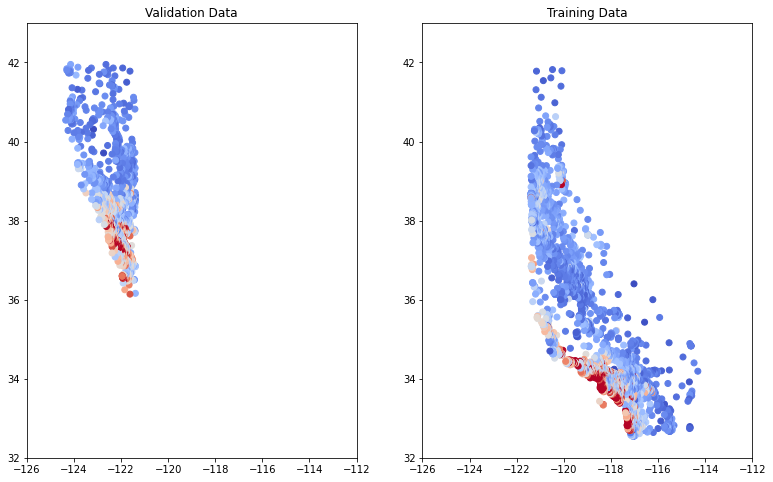

In [10]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

Tunggu dulu... Ini seharusnya memberikan kita peta negara bagian di California yang sesuai, dengan warna merah yang menandai wilayah bernilai mahal seperti San Francisco dan Los Angeles.

Set pelatihan menampilkan warna yang kurang lebih sesuai, dibandingkan dengan [peta nyata](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), namun set validasinya tidak menampilkan hal yang sama.

**Kembali lagi ke atas dan lihat data dari Tugas 1.**

Apakah Anda melihat perbedaan lain dalam distribusi fitur atau target antara data pelatihan dan validasi?

### Solusi

Klik di bawah ini untuk mendapatkan solusinya.

Dengan melihat tabel statistik ringkasan di atas, mudah memperkirakan bagaimana orang akan melakukan pemeriksaan data yang berguna. Berapa nilai persentil ke-<sup></sup>75 yang sesuai untuk total_rooms per blok kota?

Hal utama yang perlu diperhatikan adalah untuk setiap fitur atau kolom tertentu, distribusi nilai antara pembagian pelatihan dan validasi kurang lebih harus sama.

Fakta bahwa kita mendapati distribusi nilai yang tidak seimbang adalah hal yang perlu dikhawatirkan. Ini menunjukkan bahwa mungkin ada kesalahan dalam proses pembagian pelatihan dan validasi.

## Tugas 3: Kembali ke Kode Pra-Pemrosesan dan Pengimporan Data, lalu Lihat apakah Anda Menemukan Bug
Jika Anda menemukannya, periksa dan perbaiki bug tersebut. Jangan menghabiskan waktu lebih dari dua menit untuk mencarinya. Jika Anda tidak dapat menemukan bug, periksa solusinya.

Jika telah menemukan dan memperbaiki masalahnya, jalankan kembali sel penggambaran `latitude`/`longitude` di atas dan pastikan bahwa pemeriksaan kewajaran kita terlihat lebih baik.

Ada pelajaran penting yang bisa diambil di sini.

**Proses debug di ML lebih condong berupa *proses debug data*, bukan proses debug kode.**

Jika datanya salah, bahkan kode ML lanjutan yang paling canggih pun tidak dapat memperbaikinya.

### Solusi

Klik di bawah ini untuk mendapatkan solusinya.

Lihatlah cara data diacak saat dibaca.

Jika data tidak diacak dengan benar sebelum membuat pembagian validasi dan pelatihan, kita mungkin akan kesulitan jika data yang diberikan berupa susunan yang diurutkan, seperti apa yang tampaknya kita hadapi di sini.

## Tugas 4: Latih dan Evaluasi Model

**Luangkan waktu 5 menit atau lebih untuk mencoba setelan hyperparameter yang berbeda. Cobalah sebisa mungkin untuk mendapatkan performa validasi terbaik.**

Selanjutnya, kita akan melatih regresi linear menggunakan semua fitur dalam kumpulan data, dan melihat seberapa baik hasil yang didapatkan.

Mari definisikan fungsi masukan yang sama seperti yang telah digunakan sebelumnya untuk memuat data ke dalam model TensorFlow.


In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Karena saat ini kita menggunakan beberapa fitur masukan, mari memodulasikan kode untuk mengonfigurasi kolom fitur menjadi fungsi yang terpisah. (Untuk sekarang, kode ini cukup sederhana, karena semua fitur kita bersifat numerik, namun kita akan membangun kode ini karena kita menggunakan jenis fitur lainnya dalam latihan di masa mendatang.)

In [12]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

Selanjutnya, lanjutkan dan selesaikan kode `train_model()` di bawah untuk menyiapkan fungsi masukan dan menghitung prediksi.

**CATATAN:** Anda bisa merujuk kode dari latihan sebelumnya, namun pastikan untuk memanggil `predict()` pada kumpulan data yang sesuai.

Bandingkan kerugian pada data pelatihan dan data validasi. Dengan satu fitur mentah, nilai galat akar rataan kuadrat (GARK) kita adalah sekitar 180.

Lihatlah seberapa baik Anda melakukannya sekarang setelah kita dapat menggunakan beberapa fitur.

Periksa data menggunakan beberapa metode yang telah kita lihat sebelumnya. Metode ini dapat mencakup:

   * Perbandingan distribusi prediksi dan nilai target aktual

   * Pembuatan bagan sebar dari prediksi vs. nilai target

   * Pembuatan dua bagan sebar dari data validasi menggunakan `latitude` dan` longitude`:
      * Satu bagan memetakan plot ke target aktual `median_house_value`
      * Bagan kedua memetakan warna ke `median_house_value` yang telah diprediksi untuk perbandingan secara berdampingan.

In [13]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn =my_input_fn # YOUR CODE HERE
  predict_training_input_fn = # YOUR CODE HERE
  predict_validation_input_fn = # YOUR CODE HERE
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = # YOUR CODE HERE
    validation_predictions = # YOUR CODE HERE
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

SyntaxError: ignored

In [ ]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00001,
    steps=100,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah ini untuk mendapatkan solusi.

In [14]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 207.37
  period 01 : 189.97
  period 02 : 177.01
  period 03 : 169.09
  period 04 : 164.84
  period 05 : 162.71
  period 06 : 161.25
  period 07 : 160.87
  period 08 : 161.20
  period 09 : 161.61
Model training finished.


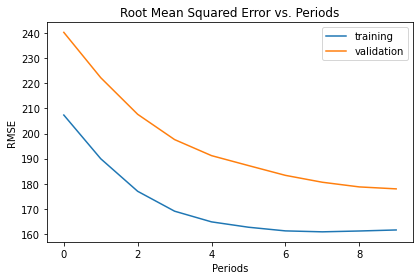

In [15]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Tugas 5: Evaluasi Data Pengujian

**Dalam sel di bawah, muat di kumpulan data pengujian dan evaluasi model Anda.**

Kita telah melakukan banyak iterasi pada data validasi. Mari pastikan kita tidak mengalami overfitting pada keunikan sampel tertentu.

Kumpulan data pengujian tersedia [di sini](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

Bagaimana performa pengujian Anda jika dibandingkan dengan performa validasi? Apa yang ditunjukkan perbandingan ini tentang performa generalisasi model Anda?

In [ ]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#
test_examples = preprocess_features(california_housing_test_data )
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
    test_examples,
    test_targets["median_house_value"],
    num_epochs=1,
    shuffle=False)
#
test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)


### Solusi

Klik di bawah ini untuk mendapatkan solusinya.

In [16]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 160.65
